In [1]:
import numpy as np
import pandas as pd


from average_atom.core.average_atom import NeutralPseudoAtom as NPA
from average_atom.core.misc import jacobi_relaxation, sor
from average_atom.core.grids import NonUniformGrid
from average_atom.core.physics import ThomasFermi, FermiDirac

from importlib import reload
try:
    reload(physics)
    reload(grids)
    reload(average_atom_geometric)
#     reload(average_atom)
    reload(misc)
except NameError as e:
    from average_atom.core import physics as physics
    from average_atom.core import average_atom as average_atom
    from average_atom.core import misc as misc
    from average_atom.core import grids as grids
    print("Error: ",e)
except Exception as e:
    print("Unexpected error during reload")
    print(e)

import matplotlib.pyplot as plt

from hnc.hnc.constants import *
from hnc.hnc.misc import rs_from_n, n_from_rs

import cProfile

plt.rcParams.update({'font.size': 10})
plt.rcParams["figure.figsize"] = (5,3.5)
plt.rcParams["figure.dpi"] = 200
plt.rcParams['xtick.labelsize']=14


color_cycle = plt.rcParams['axes.prop_cycle'].by_key()['color']



Error:  name 'physics' is not defined
ModuleNotFoundError: No module named 'mendeleev'


In [2]:
# Aluminuma
name='Al'
Z, A = 13, 27 

ρ_solid = 2.699 #g/cc, the solid density of aluminum 
ρ = ρ_solid#8.1 # g/cc
ni_cc = ρ/(A*amu_to_AU*AU_to_g)
ni_AU = ni_cc*invcc_to_AU
rs = rs_from_n(ni_AU)

Ti_eV = 1 
Te_eV = 1

Te_AU = Te_eV*eV_to_AU
Ti_AU = Ti_eV*eV_to_AU

# Hydrogen
# name='H'
# Z, A = 1, 1.00784

# Te_eV = 2 
# Te_AU = Te_eV*eV_to_AU

# Ti_eV = 2
# Ti_AU = Ti_eV*eV_to_AU

# ρ_gpercc = 1
# ni_invcc = ρ_gpercc/(A*amu_to_AU*AU_to_g)
# ni_AU = ni_invcc*invcc_to_AU
# rs = rs_from_n(ni_AU)

# Carbon
# name = 'C'
# Z, A = 6, 12.011

# ρ_gpercc = 2.267
# ni_invcc = ρ_gpercc/(A*amu_to_AU*AU_to_g)
# ni_AU = ni_invcc*invcc_to_AU
# rs = rs_from_n(ni_AU)							print("YO")


# Ti_eV = 0.5 
# Te_eV = 0.5

# Te_AU = Te_eV*eV_to_AU
# Ti_AU = Ti_eV*eV_to_AU

####
R = 10*rs
rmin = rs/1000
ignore_vxc = False
fixed_Zstar = False

aa_kwargs = {'initialize':True, 'gradient_correction':None, 'μ_init' : 0.158, 'Zstar_init' : 'More', 'rmin': 1e-5,'Npoints':1000,
             'name':name, 'ignore_vxc':ignore_vxc, 'fixed_Zstar':fixed_Zstar, 'iet_R_over_rs':R/rs, 'iet_N_bins':5000, 'use_full_ne_for_nf':False,
            'gii_init_type': 'step', 'grid_spacing':'quadratic','N_stencil_oneside':2}
npa_kwargs = {'initialize':True, 'gradient_correction':None,'μ_init' : 0.158, 'Zstar_init' : 'More', 'rmin':1e-3 ,'Npoints':1000, 
              'name':name,'ignore_vxc':ignore_vxc, 'fixed_Zstar':fixed_Zstar, 'iet_R_over_rs':R/rs, 'iet_N_bins':10000, 'use_full_ne_for_nf':False,
             'gii_init_type': 'iet', 'grid_spacing':'quadratic','N_stencil_oneside':2}

aa = NPA(Z, A, Ti_AU, Te_AU, rs, rs, **aa_kwargs)
npa = NPA(Z, A, Ti_AU, Te_AU, rs, R, **npa_kwargs)
# npa_2 = NPA(Z, A, Ti_AU, Te_AU, rs, R, **npa_kwargs)

________________________
Generating NPA
Using More TF fit for initial Zstar = 2.495
	Intializing grid
Initializing, True
Initializing
	Creating Integral Equation Solver
Intialized Potentials and Densities
Initialized
________________________
Generating NPA
Using More TF fit for initial Zstar = 2.495
	Intializing grid
Initializing, True
Initializing
	Creating Integral Equation Solver
	-------------------
	Solving IET.
0: Initial condition Total Error: 6.985e+02
Exiting status 0, reverting to best index so far: 1236
Final iter:1237, Total Error: 9.838e-13
Intialized Potentials and Densities
Initialized


### Thomas Fermi (TF)

In [3]:
%%time
from scipy.interpolate import interp1d
aa.solve_TF(verbose=True, picard_alpha=0.5, tol=1e-8, n_wait_update_Zstar= 50)
aa.set_uii_eff()
aa.iet.HNC_solve(iters_to_wait=1e5, alpha_Picard=1e-2, tol=1e-12, verbose=False, num_iterations=1e5)
aa.gii = interp1d(aa.iet.r_array*aa.rs, aa.iet.h_r_matrix[0,0]+1, bounds_error=False, fill_value='extrapolate')(aa.grid.xs)
# npa_2.gii = interp1d(npa.iet.r_array*npa.rs, aa.iet.h_r_matrix[0,0]+1, bounds_error=False, fill_value='extrapolate')(npa.grid.xs)
aa.make_ρi()

Beginning self-consistent electron solver.
_________________________________


/home/zach/plasma/average_atom/core/average_atom.py:602: RuntimeWarning: divide by zero encountered in divide
  rel_errs = (np.abs(A @ φe - b)[:-1]/b[:-1])


__________________________________________
TF Iteration 0
	μ = -9.931583698e-01, change: 5.475143762e-01 (converged=False)
	φe Err =       -inf, φe change =  7.054e-01
	ne Err =  1.449e-01, ne change =  1.480e-04
	Q =  0.000e+00 ->  1.732e+00, 
	Zstar guess =  2.495e+00. Current Zstar:  2.495e+00 (converged=True)
	Change =  1.087e+00
__________________________________________
TF Iteration 1
	μ = -6.249722393e-01, change: 3.707224766e-01 (converged=False)
	φe Err =       -inf, φe change =  4.913e-02
	ne Err =  1.398e-01, ne change =  7.360e-05
	Q =  1.732e+00 ->  1.906e+00, 
	Zstar guess =  2.495e+00. Current Zstar:  2.495e+00 (converged=True)
	Change =  3.676e-01
__________________________________________
TF Iteration 2
	μ = -4.692413615e-01, change: 2.491804724e-01 (converged=False)
	φe Err =       -inf, φe change =  1.166e-02
	ne Err =  9.739e-02, ne change =  3.729e-05
	Q =  1.906e+00 ->  1.561e+00, 
	Zstar guess =  2.495e+00. Current Zstar:  2.495e+00 (converged=True)
	Change =  2.

/home/zach/plasma/average_atom/core/average_atom.py:557: RuntimeWarning: divide by zero encountered in divide
  rel_errs = (np.abs(A @ φe - b)[:-1]/b[:-1])


Exiting status 0, reverting to best index so far: 3606
Final iter:3607, Total Error: 9.934e-13
0: Initial condition Total Error: 9.934e-13
Exiting status 0, reverting to best index so far: 1
Final iter:2, Total Error: 9.911e-13
CPU times: user 1min 43s, sys: 2min 16s, total: 3min 59s
Wall time: 1min 11s


In [4]:
from scipy.linalg import solve_banded, eig_banded, eig
# from scipy.linalg import solve_banded, eig_bande


def Ndiageig(A, N_bands_above):
	N_bands = int(N_bands_above+1) # eigs is only upper!
	N = np.shape(A)[0]
	Ab = np.zeros((N_bands, N))

	Ab[N_bands_above, :] = np.diag(A,k=0) # middle

	for i in range(1, N_bands_above + 1 ): # above
		Ab[N_bands_above - i, i:] = np.diag(A,k=i)

	# for i in range(1, N_bands_above + 1 ): # below
	# 	Ab[N_bands_above + i, :-i] = np.diag(A,k=-i)

	x = eig_banded(Ab , lower=False, select='v', select_range=(-1e20,0))
    
	return x  

A = -0.5*aa.grid.A_laplace  + np.diag(aa.get_βVeff(aa.φe, aa.ne, aa.ne_bar))
A[0,:] *= 0
A[0,0] = 1 

A[-1,:] = aa.grid.A_dfdx[-1,:]*aa.grid.xs[-1]
A[-1,-1] -= 1 


# sol = Ndiageig(A, aa.N_stencil_oneside)
sol = eig(A)
εs, vs = sol[0], sol[1].T

In [21]:
aa.grid.A_laplace.dot(aa.ne)

array([-1.63069626e+18,  6.47608995e+16,  3.73758895e+16,  2.83334320e+15,
        4.90117253e+14,  1.32228142e+14,  4.60625546e+13,  1.88735080e+13,
        8.65831729e+12,  4.32262079e+12,  2.30588587e+12,  1.29809116e+12,
        7.64433649e+11,  4.67508574e+11,  2.95540094e+11,  1.92205112e+11,
        1.28215660e+11,  8.74432131e+10,  6.08450558e+10,  4.31165721e+10,
        3.10458427e+10,  2.26849770e+10,  1.68087785e+10,  1.26058594e+10,
        9.56196482e+09,  7.33384806e+09,  5.67615879e+09,  4.43455327e+09,
        3.49440369e+09,  2.77475976e+09,  2.22017949e+09,  1.78836987e+09,
        1.45038757e+09,  1.18300116e+09,  9.71061376e+08,  8.00833760e+08,
        6.64726667e+08,  5.53591312e+08,  4.63797774e+08,  3.89988099e+08,
        3.29507807e+08,  2.79285920e+08,  2.37750799e+08,  2.03280902e+08,
        1.74156104e+08,  1.49924016e+08,  1.29257462e+08,  1.12020714e+08,
        9.72499687e+07,  8.46081858e+07,  7.39258991e+07,  6.46777244e+07,
        5.67391840e+07,  

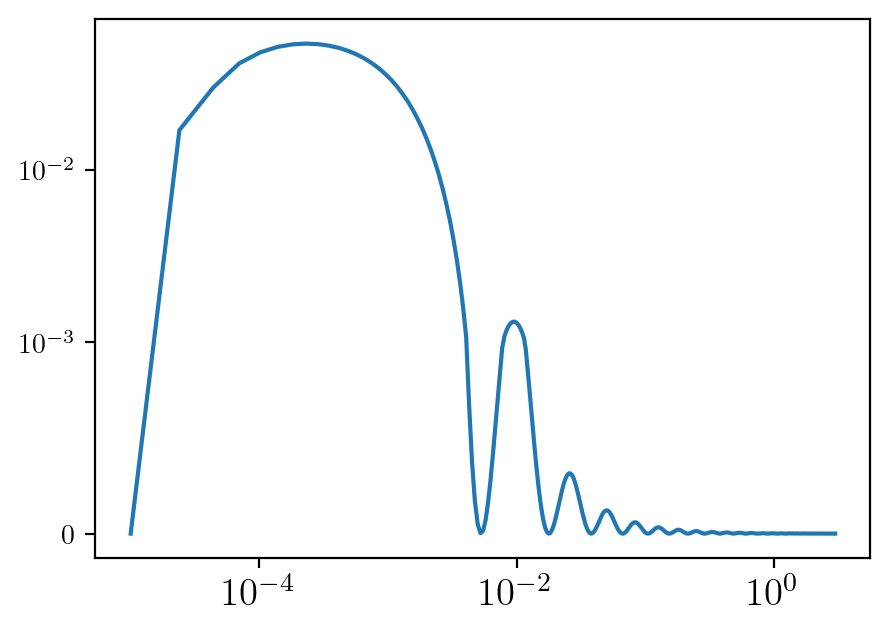

In [5]:
fig, ax = plt.subplots()


ax.plot(aa.grid.xs, vs[991]**2)

ax.set_yscale('symlog', linthresh=1e-3)
ax.set_xscale('log')

In [6]:
bound_indices =np.where(εs<0)
bound_εs = εs[bound_indices]
bound_ψs = vs[bound_indices]

/home/zach/anaconda3/envs/zplasma/lib/python3.10/site-packages/matplotlib/cbook/__init__.py:1340: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


(-97222.41919385284, 0.0)

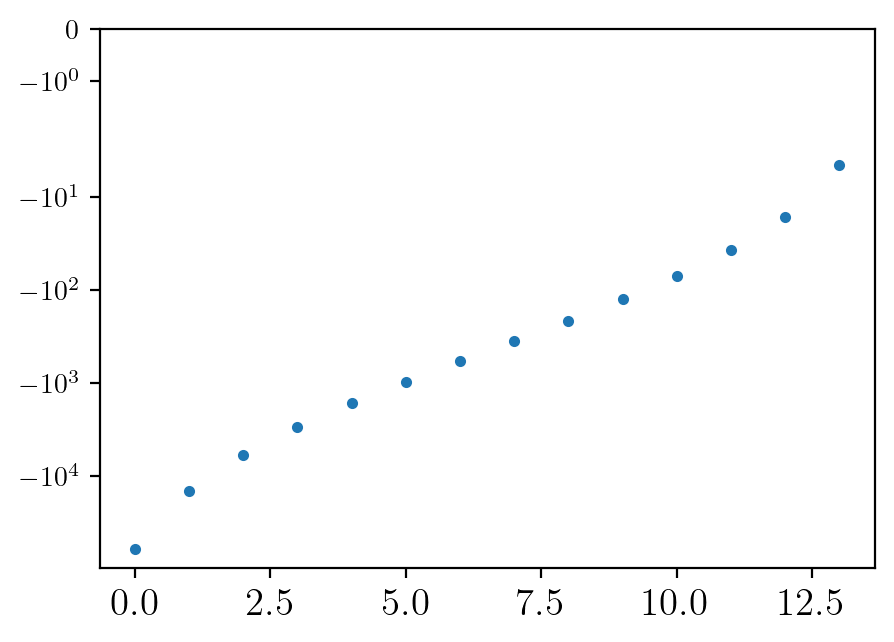

In [7]:
fig, ax = plt.subplots()

ax.plot(bound_εs,'.')
ax.set_yscale('symlog')
# ax.set_xscale('log')
ax.set_ylim(None,0)

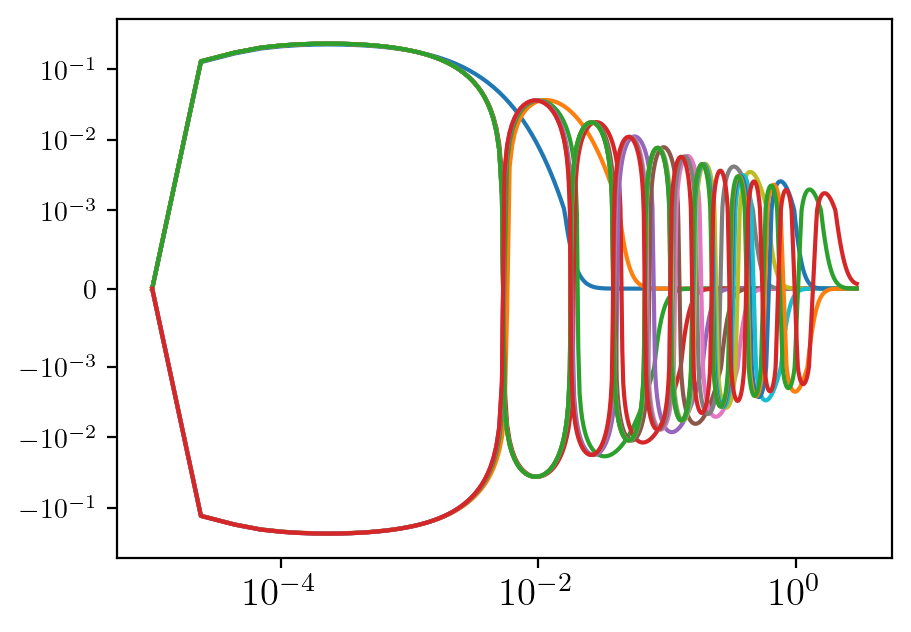

In [8]:
fig, ax = plt.subplots()

for ψ  in bound_ψs:
    ax.plot(aa.grid.xs, ψ)

ax.set_yscale('symlog', linthresh=1e-3)
ax.set_xscale('log')

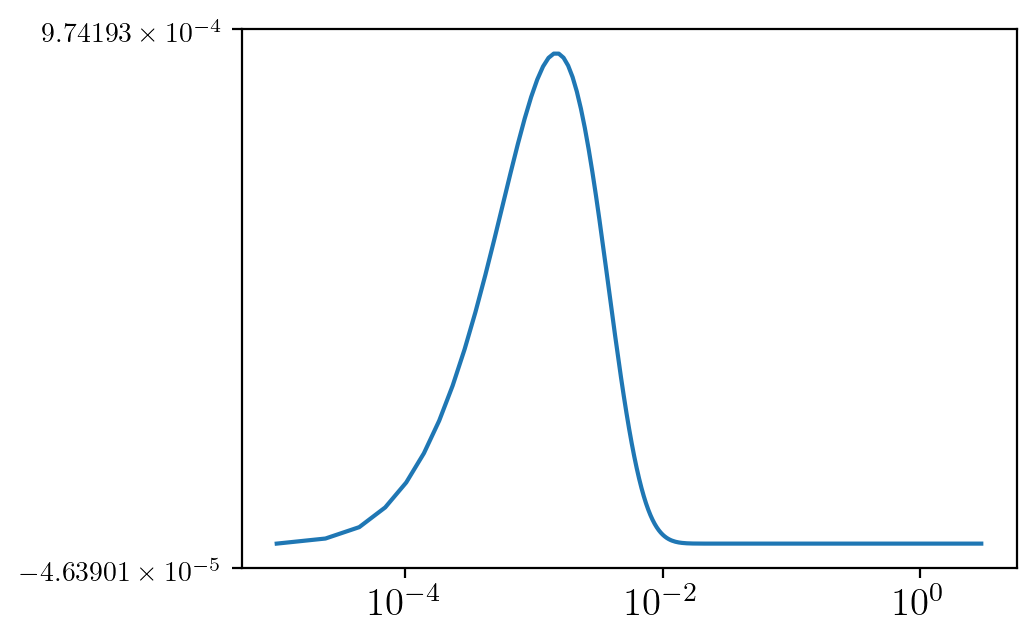

In [9]:
fig, ax = plt.subplots()

for ψ  in bound_ψs[:1]:
    ax.plot(aa.grid.xs, 4*π*aa.grid.xs*2*ψ**2)


ax.set_yscale('symlog')
ax.set_xscale('log')